# Prédiction du Loto français via du DEEP LEARNING

In [1]:
# ATTENTION!!!!
# Vérifier sur ANACONDA.NAVIGATOR que l'environement de travail est "tensorflow_env" et non "base (root)"
# Si Tensorflow n'est pas activé, Keras et d'autres librairies ne seront pas reconnues !!!

In [2]:
# Import des librairies utiles
from bs4 import BeautifulSoup
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping
from math import ceil

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
b_removeLastTirage = False
UNITS = 100 #100 #480
BATCHSIZE = 30 #30
EPOCH = 1500 #1500
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
window_length = 12 #12 #18 seems good

## I. Fonction de scraping des tirages (jusqu'à 2008)

In [4]:
# 1. Fonction de scraping des tirages du loto depuis le site loto.akroweb.fr
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [5]:
# 2. Scraping des tirages actuellement disponibles sur le site 
df_tirage=scrap_loto_numbers()
df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()

# 3. Suppression  des tirages du super loto, c'est-à-dire ceux qui ne sont pas Lundi, Mercredi, Samedi ! 
# df_tirage=df_tirage[(df_tirage['day']!='Mardi') & (df_tirage['day']!='Jeudi') & (df_tirage['day']!='Vendredi') & (df_tirage['day']!='Dimanche')]
df_tirage

,day,month_year,num0,num1,num2,num3,num4,chance
0,Mercredi,19 juillet 2023,5,11,19,35,39,9
1,Lundi,17 juillet 2023,6,9,20,41,47,9
2,Samedi,15 juillet 2023,7,12,32,42,45,6
3,Mercredi,12 juillet 2023,18,26,27,31,34,8
4,Lundi,10 juillet 2023,3,8,10,14,44,2


,day,month_year,num0,num1,num2,num3,num4,chance
0,Mercredi,19 juillet 2023,5,11,19,35,39,9
1,Lundi,17 juillet 2023,6,9,20,41,47,9
2,Samedi,15 juillet 2023,7,12,32,42,45,6
3,Mercredi,12 juillet 2023,18,26,27,31,34,8
4,Lundi,10 juillet 2023,3,8,10,14,44,2
...,...,...,...,...,...,...,...,...
2361,Mercredi,15 octobre 2008,18,20,28,40,49,1
2362,Lundi,13 octobre 2008,10,11,37,41,48,4
2363,Samedi,11 octobre 2008,10,20,22,39,46,4
2364,Mercredi,08 octobre 2008,22,24,32,41,48,1


In [6]:
# 3. Choix de la date pour la prédiction à effectuer
# --> Mettre en commentaire cette ligne si on veut prédire la date retirée du dataset
# --> Sinon, NE PAS METTRE en commentaire si on veut prédire le prochain tirage. 
last_row = len(df_tirage)-1
if b_removeLastTirage==True:
    df_tirage.drop(index=df_tirage.index[0], axis=0, inplace=True)
df_tirage

,day,month_year,num0,num1,num2,num3,num4,chance
0,Mercredi,19 juillet 2023,5,11,19,35,39,9
1,Lundi,17 juillet 2023,6,9,20,41,47,9
2,Samedi,15 juillet 2023,7,12,32,42,45,6
3,Mercredi,12 juillet 2023,18,26,27,31,34,8
4,Lundi,10 juillet 2023,3,8,10,14,44,2
...,...,...,...,...,...,...,...,...
2361,Mercredi,15 octobre 2008,18,20,28,40,49,1
2362,Lundi,13 octobre 2008,10,11,37,41,48,4
2363,Samedi,11 octobre 2008,10,20,22,39,46,4
2364,Mercredi,08 octobre 2008,22,24,32,41,48,1


## II. Traitement  des données

In [7]:
# 1. Inverser le tableau afin de placer le dernier tirage en dernière position puis choix des numéros à traiter
df = df_tirage.iloc[::-1]
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter

In [8]:
# 2. Montrer les 5 premières lignes du tableau "df"
df

,num0,num1,num2,num3,num4,chance
2365,19,24,27,33,41,9
2364,22,24,32,41,48,1
2363,10,20,22,39,46,4
2362,10,11,37,41,48,4
2361,18,20,28,40,49,1
...,...,...,...,...,...,...
4,3,8,10,14,44,2
3,18,26,27,31,34,8
2,7,12,32,42,45,6
1,6,9,20,41,47,9


## III. CUSTOM FUNCTIONS

Text(0, 0, '1')

Text(1, 0, '2')

Text(2, 0, '3')

Text(3, 0, '4')

Text(4, 0, '5')

Text(5, 0, '6')

Text(6, 0, '7')

Text(7, 0, '8')

Text(8, 0, '9')

Text(9, 0, '10')

Text(0, 1, '11')

Text(1, 1, '12')

Text(2, 1, '13')

Text(3, 1, '14')

Text(4, 1, '15')

Text(5, 1, '16')

Text(6, 1, '17')

Text(7, 1, '18')

Text(8, 1, '19')

Text(9, 1, '20')

Text(0, 2, '21')

Text(1, 2, '22')

Text(2, 2, '23')

Text(3, 2, '24')

Text(4, 2, '25')

Text(5, 2, '26')

Text(6, 2, '27')

Text(7, 2, '28')

Text(8, 2, '29')

Text(9, 2, '30')

Text(0, 3, '31')

Text(1, 3, '32')

Text(2, 3, '33')

Text(3, 3, '34')

Text(4, 3, '35')

Text(5, 3, '36')

Text(6, 3, '37')

Text(7, 3, '38')

Text(8, 3, '39')

Text(9, 3, '40')

Text(0, 4, '40')

Text(1, 4, '41')

Text(2, 4, '42')

Text(3, 4, '43')

Text(4, 4, '45')

Text(5, 4, '46')

Text(6, 4, '47')

Text(7, 4, '48')

Text(8, 4, '49')

Text(9, 4, '50')

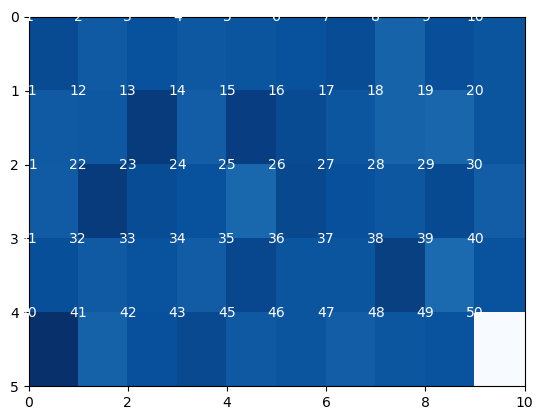

In [9]:
# 0. Liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

# 1. Fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_over(data, number):
    return ((data['num0'] >= number).astype(int) + 
            (data['num1'] >= number).astype(int) +
            (data['num2'] >= number).astype(int) +
            (data['num3'] >= number).astype(int) +
            (data['num4'] >= number).astype(int))

# 1.BIS Fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

# 2. Fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

# 3. Fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

# 4. Fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

# 5. Fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

# 6. Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)

# 7. Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
    
def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs

# 7.Créer la heatmap des fréquences de chaque numéro
harvest = np.array([['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                    ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
                    ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30'], 
                    ['31', '32', '33', '34', '35', '36', '37', '38', '39', '40'], 
                    ['40', '41', '42', '43', '45', '46', '47', '48', '49', '50']])

fig, ax = plt.subplots()
ax.invert_yaxis()
# Loop over data dimensions and create text annotations.
for y in range(5):
    for x in range(10):
        plt.text(x ,y, harvest[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = "w")
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

# # === Trouver les numéros les moins fréquents
df["min_freq_nums_0"] = np.nan
df["min_freq_nums_1"] = np.nan
df["min_freq_nums_2"] = np.nan
df["min_freq_nums_3"] = np.nan
df["min_freq_nums_4"] = np.nan
df["min_freq_nums_5"] = np.nan
df["min_freq_nums_6"] = np.nan
df["min_freq_nums_7"] = np.nan
df["min_freq_nums_8"] = np.nan
df["min_freq_nums_9"] = np.nan
df["min_freq_nums_10"] = np.nan

df["max_freq_nums_0"] = np.nan
df["max_freq_nums_1"] = np.nan
df["max_freq_nums_2"] = np.nan
df["max_freq_nums_3"] = np.nan
df["max_freq_nums_4"] = np.nan
df["max_freq_nums_5"] = np.nan
df["max_freq_nums_6"] = np.nan
df["max_freq_nums_7"] = np.nan
df["max_freq_nums_8"] = np.nan
df["max_freq_nums_9"] = np.nan
df["max_freq_nums_10"] = np.nan
# Pour chaque ligne, calculer la fréquence de chaque numéro et obtenir les 11 numéros les moins fréquents
min_freq_nums = []
len_df = len(df)
cnt_idx = 0
for index, row in df.iterrows():
    cnt_idx = cnt_idx +1
    freqs = []
    for val in range(50):
        count = ( (df['num0'][0:cnt_idx] == val+1).sum() +
                  (df['num1'][0:cnt_idx] == val+1).sum() +
                  (df['num2'][0:cnt_idx] == val+1).sum() +
                  (df['num3'][0:cnt_idx] == val+1).sum() +
                  (df['num4'][0:cnt_idx] == val+1).sum())
        freqs.append(count)
    freqs.remove(0)
    sorted_counts = np.sort(freqs)
    original_index = np.argsort(freqs)+1
    df["min_freq_nums_0"].loc[cnt_idx-1] = original_index[0]
    df["min_freq_nums_1"].loc[cnt_idx-1] = original_index[1]
    df["min_freq_nums_2"].loc[cnt_idx-1] = original_index[2]
    df["min_freq_nums_3"].loc[cnt_idx-1] = original_index[3]
    df["min_freq_nums_4"].loc[cnt_idx-1] = original_index[4]
    df["min_freq_nums_5"].loc[cnt_idx-1] = original_index[5]
    df["min_freq_nums_6"].loc[cnt_idx-1] = original_index[6]
    df["min_freq_nums_7"].loc[cnt_idx-1] = original_index[7]
    df["min_freq_nums_8"].loc[cnt_idx-1] = original_index[8]
    df["min_freq_nums_9"].loc[cnt_idx-1] = original_index[9]
    df["min_freq_nums_10"].loc[cnt_idx-1] = original_index[10]
    df["max_freq_nums_0"].loc[cnt_idx-1] = original_index[48]
    df["max_freq_nums_1"].loc[cnt_idx-1] = original_index[47]
    df["max_freq_nums_2"].loc[cnt_idx-1] = original_index[46]
    df["max_freq_nums_3"].loc[cnt_idx-1] = original_index[45]
    df["max_freq_nums_4"].loc[cnt_idx-1] = original_index[44]
    df["max_freq_nums_5"].loc[cnt_idx-1] = original_index[43]
    df["max_freq_nums_6"].loc[cnt_idx-1] = original_index[42]
    df["max_freq_nums_7"].loc[cnt_idx-1] = original_index[41]
    df["max_freq_nums_8"].loc[cnt_idx-1] = original_index[40]
    df["max_freq_nums_9"].loc[cnt_idx-1] = original_index[40]
    df["max_freq_nums_10"].loc[cnt_idx-1] = original_index[39]



## IV. Création de features additionnels a partir de nos données de base.

In [10]:
# # 1. Ajout de la difference entre les numéros(A explorer ASAp)
# for i in range(4):
#     #print(i,i+1)
#     df['diff_{}'.format(i)]=df['num{}'.format(i+1)]-df['num{}'.format(i)]
    
#2. Application des fonctions sur le dataframe
df['freq_num0'] = freq_val(df, 'num0')     # Calcul des frequences 
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')
df['sum_diff'] = sum_diff(df)              # Somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)     # Pair chance? 
df['impair_chance'] = is_impair_etoile(df) # Impair chance?
df['pair'] = is_pair(df)                   # Pair numéros ?
df['impair'] = is_impair(df)               # Impair numéros ?


summmm = df.num0 + df.num1 + df.num2 + df.num3 + df.num4 + df.chance 
summmm = (summmm > 80) & (summmm < 177) 
df['sum_between_77_173'] = summmm
df['sum_between_77_173'] = df.sum_between_77_173.replace({True: 1, False: 0})

if b_removeLastTirage==True:
    df.drop(index=df_tirage.index[last_row-1], axis=0, inplace=True)
df


,num0,num1,num2,num3,num4,chance,min_freq_nums_0,min_freq_nums_1,min_freq_nums_2,min_freq_nums_3,...,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,sum_between_77_173
2365,19,24,27,33,41,9,39.0,25.0,19.0,18.0,...,1,1,1,1,134,0,1,1,4,1
2364,22,24,32,41,48,1,39.0,25.0,19.0,18.0,...,1,1,1,1,198,0,1,4,1,1
2363,10,20,22,39,46,4,39.0,25.0,19.0,18.0,...,1,1,1,1,442,1,0,4,1,1
2362,10,11,37,41,48,4,39.0,25.0,19.0,18.0,...,1,2,2,2,742,1,0,2,3,1
2361,18,20,28,40,49,1,39.0,25.0,19.0,18.0,...,1,1,1,2,293,0,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,8,10,14,44,2,1.0,46.0,44.0,43.0,...,27,10,150,220,945,1,0,4,1,1
3,18,26,27,31,34,8,1.0,24.0,48.0,27.0,...,96,81,55,215,90,1,0,3,2,1
2,7,12,32,42,45,6,1.0,48.0,27.0,28.0,...,68,82,170,217,534,1,0,3,2,1
1,6,9,20,41,47,9,1.0,48.0,27.0,28.0,...,83,116,197,245,607,0,1,2,3,1


## V. Modèle et fonction de formatage des données en entrée du LSTM

In [11]:
# Dans cette partie, trois modèles sont disponibles : define_model() pour du LSTM classique, 
# define_bidirectionnel_model() pour du bi-directionnel et define_autoencoder_model()
from keras.layers import LSTM, Dense, Bidirectional, Dropout
# Commentaire : window_length = 12 correspond à un apprentissage sur 1 mois de données 

# 1. Paramètress du modèle
nb_label_feature=6 # Pour les 5 numéros et numéro chance
number_of_features = df.shape[1]

# 2. Architecture du modèle
def define_bimodel(number_of_features,nb_label_feature):
    # Initialising the RNN
    model = Sequential()
    # Adding the input layer and the LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a first Dropout layer
    model.add(Dropout(0.2))
    # Adding a second LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a second Dropout layer
    model.add(Dropout(0.2))
    # Adding a third LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a fourth LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = False)))
    # Adding a fourth Dropout layer
    model.add(Dropout(0.2))
    # Adding the first output layer
    model.add(Dense(59))
    # Adding the last output layer
    model.add(Dense(number_of_features))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.2, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(240, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(120, return_sequences=True))
    model.add(LSTM(240, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model


# 3. Moniteur pour arreter le training 
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=40) #patience=100)

In [12]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature) #define_model
        
    return train, label, model,scaler

## VI. Training

In [13]:
#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)

 

(2354, 12, 40)
(2354, 6)


In [14]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2,callbacks=[es]) # callbacks=[es]

Epoch 1/1500
79/79 - 5s - loss: 0.8190 - acc: 0.1585 - 5s/epoch - 60ms/step
Epoch 2/1500
79/79 - 1s - loss: 0.8057 - acc: 0.1729 - 878ms/epoch - 11ms/step
Epoch 3/1500
79/79 - 1s - loss: 0.7992 - acc: 0.1873 - 823ms/epoch - 10ms/step
Epoch 4/1500
79/79 - 1s - loss: 0.7917 - acc: 0.1920 - 839ms/epoch - 11ms/step
Epoch 5/1500
79/79 - 1s - loss: 0.7877 - acc: 0.2035 - 816ms/epoch - 10ms/step
Epoch 6/1500
79/79 - 1s - loss: 0.7774 - acc: 0.2128 - 825ms/epoch - 10ms/step
Epoch 7/1500
79/79 - 1s - loss: 0.7697 - acc: 0.2268 - 845ms/epoch - 11ms/step
Epoch 8/1500
79/79 - 1s - loss: 0.7604 - acc: 0.2489 - 860ms/epoch - 11ms/step
Epoch 9/1500
79/79 - 1s - loss: 0.7455 - acc: 0.2668 - 845ms/epoch - 11ms/step
Epoch 10/1500
79/79 - 1s - loss: 0.7352 - acc: 0.2676 - 836ms/epoch - 11ms/step
Epoch 11/1500
79/79 - 1s - loss: 0.7222 - acc: 0.2740 - 857ms/epoch - 11ms/step
Epoch 12/1500
79/79 - 1s - loss: 0.7076 - acc: 0.2927 - 836ms/epoch - 11ms/step
Epoch 13/1500
79/79 - 1s - loss: 0.6944 - acc: 0.302

## Fonction de perte 

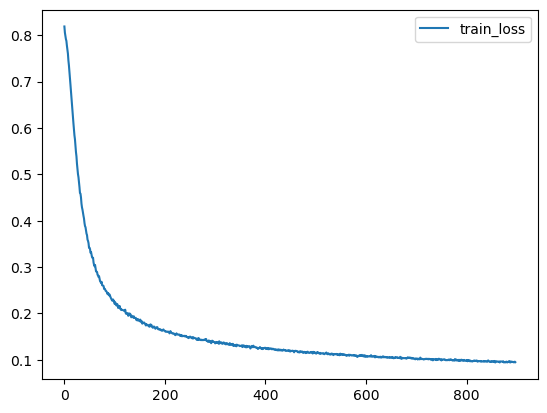

In [15]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Fonction Metric "acc" (à maximiser)

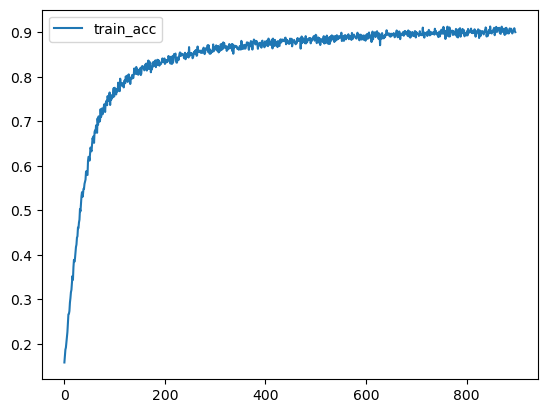

In [16]:
plt.plot(history.history['acc'])
plt.legend(['train_acc'])
plt.show()

## Prédiction du tirage suivant le dernier tirage de notre dataset de train

In [19]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
scaled_predicted_output_1


1/1 [==============================] - 0s 24ms/step


array([[ 0.12943116,  0.06540057, -0.69369847, -0.07639349, -0.4689057 ,
         0.56515896]], dtype=float32)

In [18]:
#prediction using scaled_to_predict
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])


[ 9 17 18 32 38  7]
